# COGS 108 - Final Project 

# Overview

Restaurant health inspection scores' correlation to various socioeconomic metrics is explored by a zipcode-level breakdown of patterns in SE indicators. It is hypothesized that there is little correlation between median income and scores in a given community. This is explicated using data visualization and statistical analysis. The hypothesis appears to be supported by the data. Health inspection scores correlate very weakly indeed with all manner of available socioeconomic metrics.

# Name & GitHub

- Name: Ryan Arroyo
- GitHub Username: rjarroyo

# Research Question

How strongly do restaurant health inspection scores correlate to socioeconomic status metrics of the zip codes that the restaurants are located in?

## Background and Prior Work

Previous work to address this question has been conducted. First, a 2017 study of “Sociodemographic Factors and Food Safety Violations in Chain and Nonchain Restaurants” explored the relationship between inspection frequency, neighborhood characteristics, and inspection outcomes. Notably, the study revealed an interesting correlation—a higher proportion of black residents in a restaurant’s neighborhood was associated with a reduction in mean “foodborne-illness risk factor” violations, but an increase in mean “good retail practice” violations. On a related note, Andy Chang’s article for towardsdatascience.com explored this topic in context of the ethics of training a machine-learning model. He observed that generation of word clouds correlating to a bad health inspection score based on a restaurant name dataset led to prevalent words such as “Mexican” or “Taqueria”. His article details the ethical implications of teaching a model that, for example, “taqueria” named restaurants tend to score lower than “pizza” restaurants.

This project explores a more limited scope-- the only non-economic metric gathered by zip code is the rather unspecific "percent nonwhite" value. This appears to correlate somewhat to economic metrics of zip-codes, which may be worth further exploration.

References (include links):
- 1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/ 
- 2) https://towardsdatascience.com/teaching-a-xenophobic-ai-health-inspector-and-the-ethics-of-machine-learning-b644d72376f 

# Hypothesis


I predict that health inspection scores are weakly correlated to median income in a given restaurant’s zip code. I believe this to be true because a business’s incentive to perform well is the rational self-interest of its owners and operators, in order to protect and improve their livelihoods. Customers are invested in the safety and quality of their food, regardless of socioeconomic status, which directly impacts business performance of restaurants, regarding health practices.


# Dataset(s)

- Dataset Name: Inspections
- Link to the dataset: /data/inspections.csv
- Number of observations: 18466 rows

Line-item dataset of, presumably, all restaurant health inspections conducted in Wake County, NC between Sept.21, 2012 and Nov.3, 2016.


- Dataset Name: Zipcodes
- Link to the dataset: /data/zipcodes.csv
- Number of observations: 38 rows

Socioeconometric dataset broken down by zip code. Also contains information on percent nonwhite population.



Datasets will be utilized by creating look-up dictionaries from Zipcodes dataset in order to compare against health inspection scores from Inspections dataset, with the goal of exploring correlations between SES and average inspection scores.

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')


import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.



In [2]:
df_ins = pd.read_csv('data/inspections.csv')
df_zip = pd.read_csv('data/zipcodes.csv')

# Data Cleaning

This project benefits from having a rather larger Inspection data set to work with-- I have nearly 20,000 rows! As such, it is well suited to investigating trends. 

Since I'm simply comparing inspection scores to socioeconometrics by zip code, I only need a few columns from the inspection dataframe. I start by taking only the 'zip' and 'score' columns, noting that there are no NaNs in either.



In [3]:
df_ins['zip'].hasnans
df_ins['score'].hasnans

df_score = df_ins[['zip','score']]
df_score.shape

(18466, 2)

Next, I fetch a list of represented zip codes, index our socioeconometrics by zip code, rename the columns to more concise labels, and construct a dictionary with zip-indexed entries for each metric column.

In [4]:
zip_set = df_zip['zip'].to_list()

df_zip.set_index('zip', inplace=True)
df_zip = df_zip.rename(
    {'median_family_income_dollars' :         'med_fam$', 
     'median_household_income_dollars' :      'med_hou$', 
     'per_capita_income_dollars' :            'percap_$', 
     'percent_damilies_below_poverty_line' :  'per_fampov', 
     'percent_snap_benefits' :                'per_snap', 
     'percent_supplemental_security_income' : 'per_ssi', 
     'percent_nonwhite' :                     'per_nw'}, 
    axis = 'columns')

zip_dict = df_zip.to_dict() 

Next, I account for coverage of our zip-metric dictionary, by dropping any zip values in our inspection dataset that do not have associated data in the dictionary.



In [5]:
df_score = df_score[df_score['zip'].isin(zip_set)]
df_score.shape

(18231, 2)

Noting that over 200 entries in df_score were not represented in our dict, I now have a simple, clean dataframe with a data dictionary correlating socioeconometrics to every score by zipcode. Finally, I will create our analysis dataframe by assigning new columns to my dataframe based on dictionary entries corresponding to each score's zip.

In [6]:
dfa = df_score
dfa['med_fam$']= df_score['zip'].map(zip_dict['med_fam$'])
dfa['med_hou$']= df_score['zip'].map(zip_dict['med_hou$'])
dfa['percap_$']= df_score['zip'].map(zip_dict['percap_$'])
dfa['per_fampov']= df_score['zip'].map(zip_dict['per_fampov'])
dfa['per_snap']= df_score['zip'].map(zip_dict['per_snap'])
dfa['per_ssi']= df_score['zip'].map(zip_dict['per_ssi'])
dfa['per_nw']= df_score['zip'].map(zip_dict['per_nw'])
dfa

,zip,score,med_fam$,med_hou$,percap_$,per_fampov,per_snap,per_ssi,per_nw
0,27610,96.0,49213,45209,19207,19.2,16.9,5.9,72.7
1,27610,98.0,49213,45209,19207,19.2,16.9,5.9,72.7
2,27610,97.0,49213,45209,19207,19.2,16.9,5.9,72.7
3,27513,99.0,109736,87262,41232,3.8,2.4,1.5,27.8
4,27597,97.0,59395,51266,21573,11.3,15.5,7.5,26.3
...,...,...,...,...,...,...,...,...,...
18461,27616,93.0,60033,56323,24549,11.7,10.6,4.6,52.6
18462,27513,97.0,109736,87262,41232,3.8,2.4,1.5,27.8
18463,27519,96.0,137193,121815,45778,3.2,2.3,2.3,35.2
18464,27603,99.0,68608,54889,27843,12.6,10.4,3.8,25.6


Finally, I am ready to explore the data!

# Data Analysis & Results

I begin with some exploratory data analysis.

### EDA

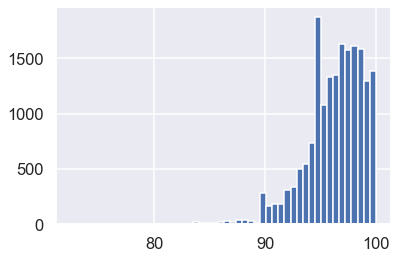

In [7]:
#A simple histogram of scores (below) shows, thankfully, a heavily skewed distribution of scores > 95.
dfa['score'].hist(bins=50)

f1 = plt.gcf()

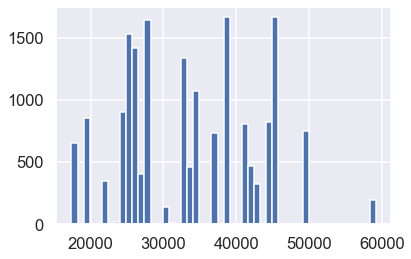

In [8]:
#A simple histogram of per capita income (below) shows a diverse economic representation of zip codes. 
#This appears to be a somewhat random distribution. 
dfa['percap_$'].hist(bins=50)

f2 = plt.gcf()

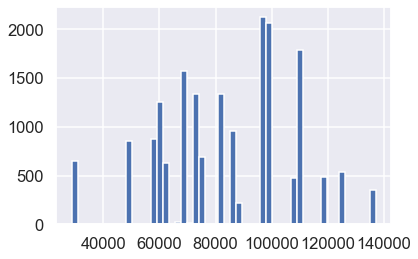

In [9]:
#A simple histogram of median family income (below) shows a diverse economic representation of zip codes. 
#However, unlike per-capita metrics, this has a more normal shape. 
dfa['med_fam$'].hist(bins=50)

f3 = plt.gcf()

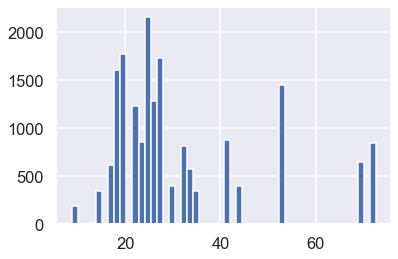

In [10]:
#A simple histogram of racial homogeneity (below) shows that most represented zipcodes are majority white populations,
# with about 1/3 nonwhite residents on average. There are three outlier zip codes where whites are a minority. 
dfa['per_nw'].hist(bins=50)

f4 = plt.gcf()

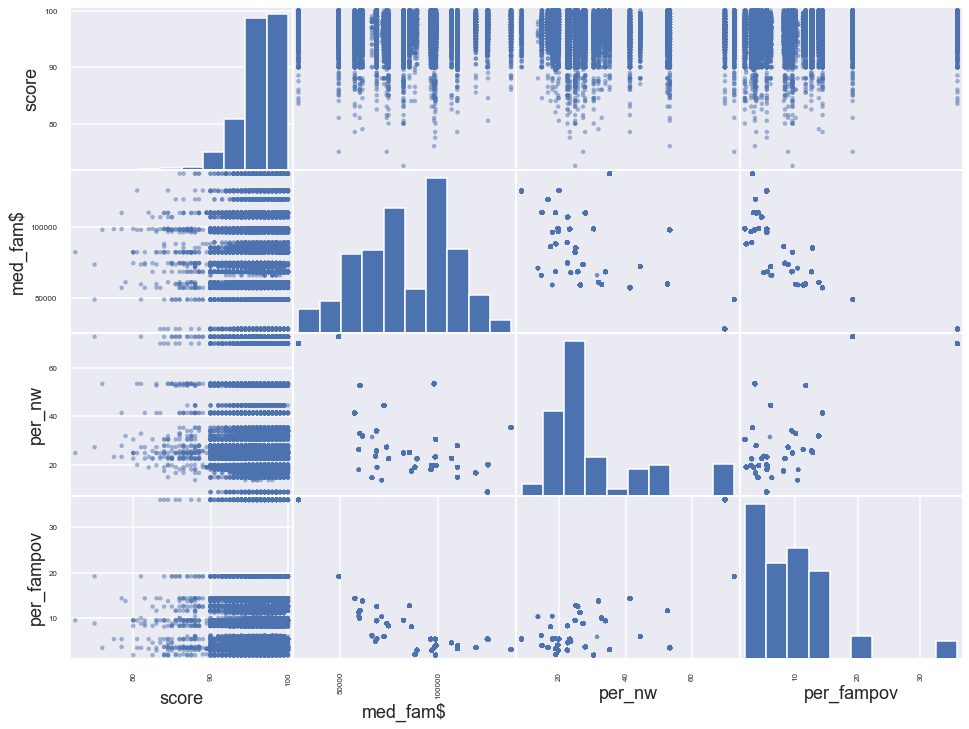

In [11]:
#Finally, I create a scatterplot matrix comparing scores to median family income and racial homogeneity, as well as the 
#percentage of each zip code's families with income below the poverty line.
pd.plotting.scatter_matrix(dfa[['score','med_fam$','per_nw', 'per_fampov']], figsize = [16,12])

f5 = plt.gcf()

The plot above guides the forthcoming analysis-- while there does appear to be some correlation between racial homogeneity and median family income (to be expected, given historical context of economic challenges faced by diverse populations), there is no apparent pattern between inspection scores and either median family income, percentage of families in poverty, or racial homogeneity. This can be seen by the dense clustering of scores above the "90" line in score vs. X graphs above, and their gradual tapering off below 90-- apparent at all levels of the comparison graphs.

A more in-depth mathematical analysis will demonstrate this more convincingly.

### Statistical Analysis

Finally, I use descriptive and correlative methods from pandas to take a look at our data mathematically.  The nature of our dataset and zip-code dictionary of socioeconomic metrics lends itself to a simple statistical analysis looking at correlations between health scores and metrics.

In [12]:
desc = dfa.describe()
desc

,zip,score,med_fam$,med_hou$,percap_$,per_fampov,per_snap,per_ssi,per_nw
count,18231.000000,18231.000000,18231.000000,18231.000000,18231.000000,18231.000000,18231.000000,18231.000000,18231.000000
mean,27576.463496,96.222807,83634.644123,67269.754484,33548.159618,9.192162,7.809467,3.042702,31.457770
std,41.176900,2.658497,23481.418903,18702.356029,9217.563851,6.773915,6.260982,2.145486,15.579884
min,27501.000000,72.500000,28641.000000,27564.000000,17363.000000,2.000000,1.000000,0.500000,8.700000
25%,27529.000000,95.000000,68608.000000,53640.000000,25807.000000,4.200000,4.200000,1.500000,22.400000
50%,27603.000000,96.500000,82292.000000,67392.000000,33139.000000,8.400000,6.400000,2.300000,25.600000
75%,27610.000000,98.000000,98642.000000,80324.000000,41232.000000,12.600000,10.200000,3.900000,35.200000
max,27617.000000,100.000000,137193.000000,121815.000000,59155.000000,35.900000,33.500000,15.400000,72.700000


In [13]:
corrs = dfa.corr()
corrs

,zip,score,med_fam$,med_hou$,percap_$,per_fampov,per_snap,per_ssi,per_nw
zip,1.000000,0.008912,-0.316423,-0.475690,-0.091375,0.300745,0.364473,0.232588,0.202308
score,0.008912,1.000000,0.031629,0.025052,0.011425,-0.009235,-0.013785,-0.002334,-0.030941
med_fam$,-0.316423,0.031629,1.000000,0.902850,0.879557,-0.833787,-0.817556,-0.724067,-0.654815
med_hou$,-0.475690,0.025052,0.902850,1.000000,0.733858,-0.789446,-0.755190,-0.656079,-0.520016
percap_$,-0.091375,0.011425,0.879557,0.733858,1.000000,-0.748441,-0.729012,-0.733589,-0.594429
per_fampov,0.300745,-0.009235,-0.833787,-0.789446,-0.748441,1.000000,0.940886,0.861786,0.682533
per_snap,0.364473,-0.013785,-0.817556,-0.755190,-0.729012,0.940886,1.000000,0.911719,0.674544
per_ssi,0.232588,-0.002334,-0.724067,-0.656079,-0.733589,0.861786,0.911719,1.000000,0.581725
per_nw,0.202308,-0.030941,-0.654815,-0.520016,-0.594429,0.682533,0.674544,0.581725,1.000000


Our takeaways from the scattermatrix are supported by the numbers here! Score correlates with median family income with a p value of only 0.03, with a similarly tiny correlation between score and racial homogeneity (per_nw).Of course, as observed, there is a strong correlation between racial homogenieity and median family income, with p = -0.65.

Perhaps most interesting, the metric with single weakest correlation to score (p < 0.01!) is "per_fampov"-- indicating that there is basically no connection between restaurant health scores and impoverished communities. 

# Ethics & Privacy

Privacy concerns with this project are minimal since key data is drawn from public statistics and inspection results. However, as noted in background work, there are ethical considerations surrounding data correlations involving socioeconomic status and culturally attributable data, particularly when that data is taken as extrapolatable.

In this case, since data is completely anonymized by the dropping of all restaurant-related data but score & zip code, privacy concerns are a non-issue. However, given the scope of drawing conclusions about trends in society, particularly when discussing matters of economy and especially race, it is important for a data scientist to check their biases when forming hypotheses, and particularly when drawing conclusions. Preconceptions must be analyzed through the lens of objectivity, and conclusions must be presented carefully in a way that does not provide ammunition for those who wish to draw an unsavory picture of groups of people without robust rational grounds. 

# Conclusion & Discussion

The hypothesis appears to be supported by the data. Health inspection scores correlate very weakly indeed with all manner of available socioeconomic metrics. This is apparent both when graphing a scattermatrix comparing scores to SE metrics, as well as when looking at statistical analyses of the data. 


Despite my initial biases when considering this project, in which I assumed emotionally (of which I am not proud!) that "poor community = dirtier restaurants", my hypothesis that there would be little correlation in actuality appears to be true. I conceptualize this by the notion that anyone operating a restaurant has a strong incentive to be clean, for the sake of their continuing business performance and reputation-- public opinion is perhaps a bigger threat to a restaurant's success than a city representative's rating, and subpar performers are likely to fail quickly.

This project reinforces a noble notion that poverty does not diminish humanity, and that people from all walks of life expect, deserve, and -- provided they budget for it-- recieve access to clean and safe food when eating out. 
